### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import anderson
from scipy.stats import kruskal
import statsmodels.api as sm
import pmdarima as pm

import numpy as np

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


### Data Reading

In [2]:
d= pd.read_excel('SeoulBikeData.xlsx')
d['Date']= pd.to_datetime(d['Date'])
print(d.columns)

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')


In [3]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Rented Bike Count          8760 non-null   int64         
 2   Hour                       8760 non-null   int64         
 3   Temperature(°C)            8760 non-null   float64       
 4   Humidity(%)                8760 non-null   int64         
 5   Wind speed (m/s)           8760 non-null   float64       
 6   Visibility (10m)           8760 non-null   int64         
 7   Dew point temperature(°C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)    8760 non-null   float64       
 9   Rainfall(mm)               8760 non-null   float64       
 10  Snowfall (cm)              8760 non-null   float64       
 11  Seasons                    8760 non-null   object        
 12  Holida

In [4]:
d.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


Adding date time column

In [5]:
d= d.sort_values(['Date', 'Hour'])
d['Datetime'] = d['Date'] + pd.to_timedelta(d['Hour'], unit='h')
d= d.reset_index(drop= True)

## Phase 1

#### Functioning Days

Before everything, we start by analyzing functioning days!
Since this fact is important, this is the first thing we do.

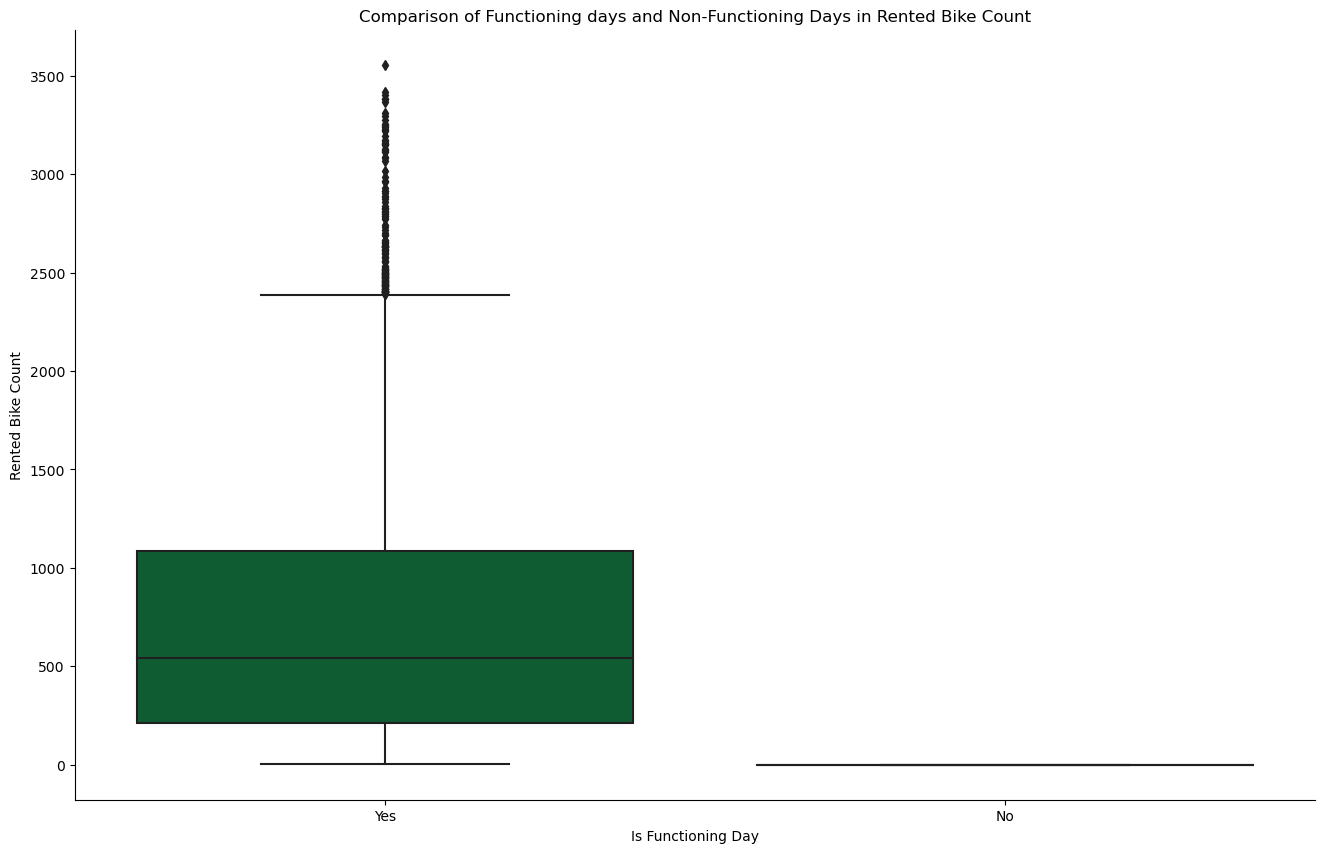

In [6]:
plt.figure(figsize=(16, 10))

sns.boxplot(x=d['Functioning Day'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            )

# Set title and labels
plt.title('Comparison of Functioning days and Non-Functioning Days in Rented Bike Count')
plt.xlabel('Is Functioning Day')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


We can see that the demand is always 0 when the company doesn't function. To better say it, actully not the demand but using of the bikes is zero when the system doesn't provide the service. By knowing this fact, we can say it is obvious to set estimated demand to zero when we are in a non-functioning time. Since the algorithms don't handle this criteria well, we first filter all of the points that the system doesn't function and also remove this column. By knowing this rule, we simply set demand to zero in nonfunctioning days.

In [7]:
d= d[d['Functioning Day']== 'Yes']
d= d.drop('Functioning Day', axis= 1)

### Part 1

Here we analyze the count of rented bikes.

#### Trend

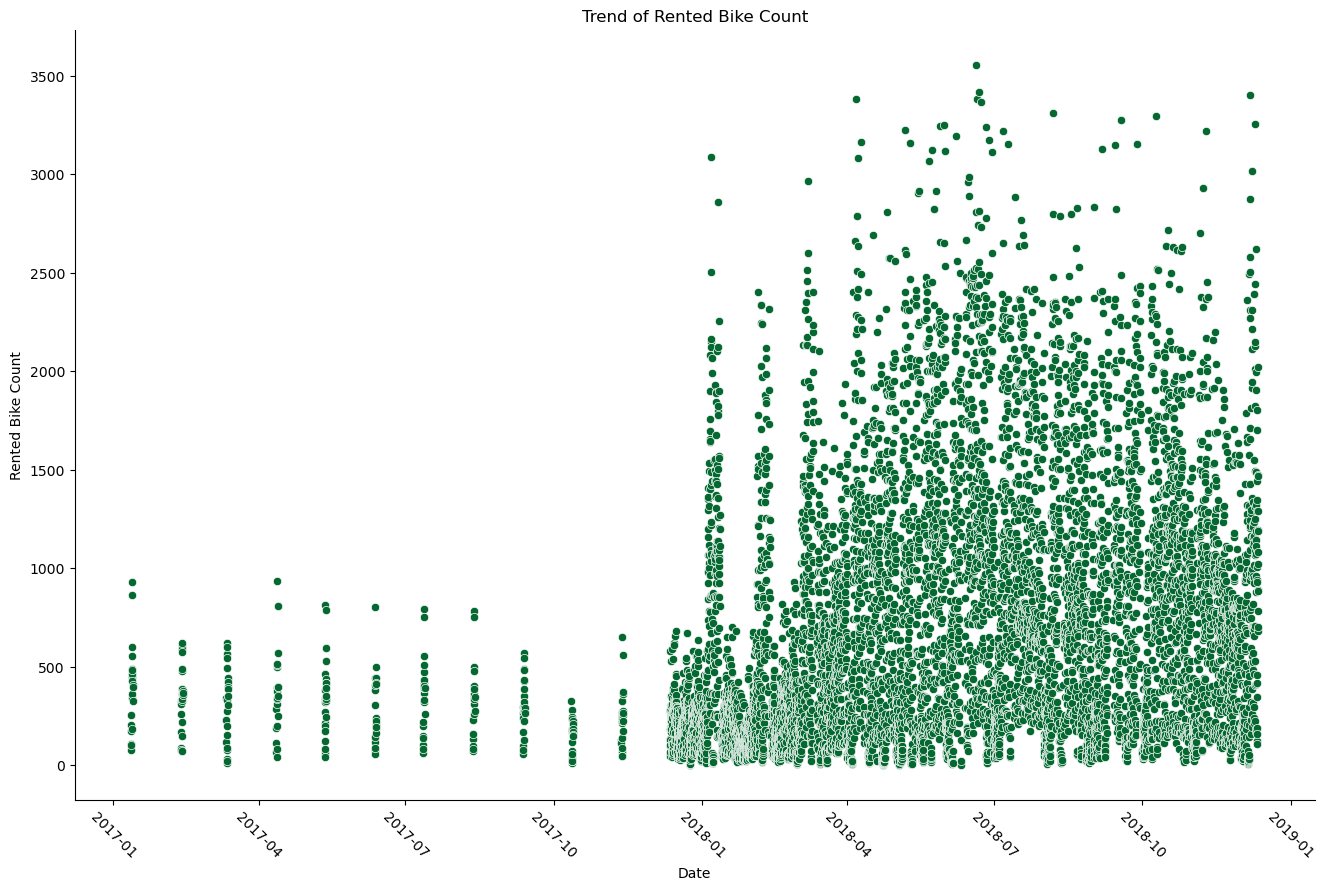

In [8]:
plt.figure(figsize=(16, 10))

sns.scatterplot(x=d['Datetime'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            ci= None
            )

# Set title and labels
plt.title('Trend of Rented Bike Count')
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')

plt.xticks(rotation= -45)
# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


We see that we have very little data before 2018:

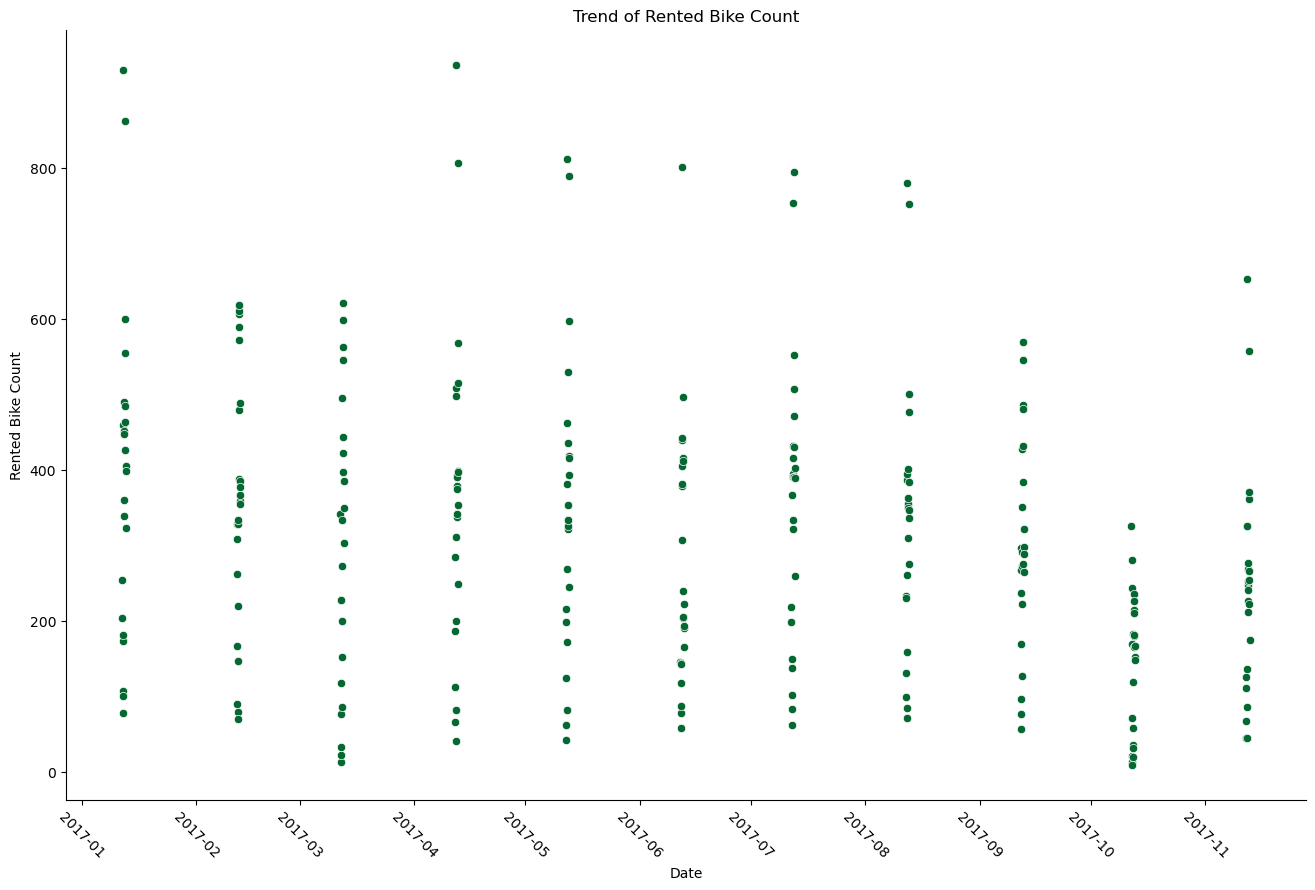

In [9]:
plt.figure(figsize=(16, 10))

sns.scatterplot(x=d[d['Date']<= '2017-12-01']['Datetime'], 
            y=d[d['Date']<= '2017-12-01']['Rented Bike Count'], 
            color='#046830', 
            ci= None
            )

# Set title and labels
plt.title('Trend of Rented Bike Count')
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')

plt.xticks(rotation= -45)
# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


Since demand in this horizon is completely different from the other years, we only use the data after 2018.

In [10]:
d= d[d['Date']>= '2018-01-01']

Now we can see that the demand trend is more rational.

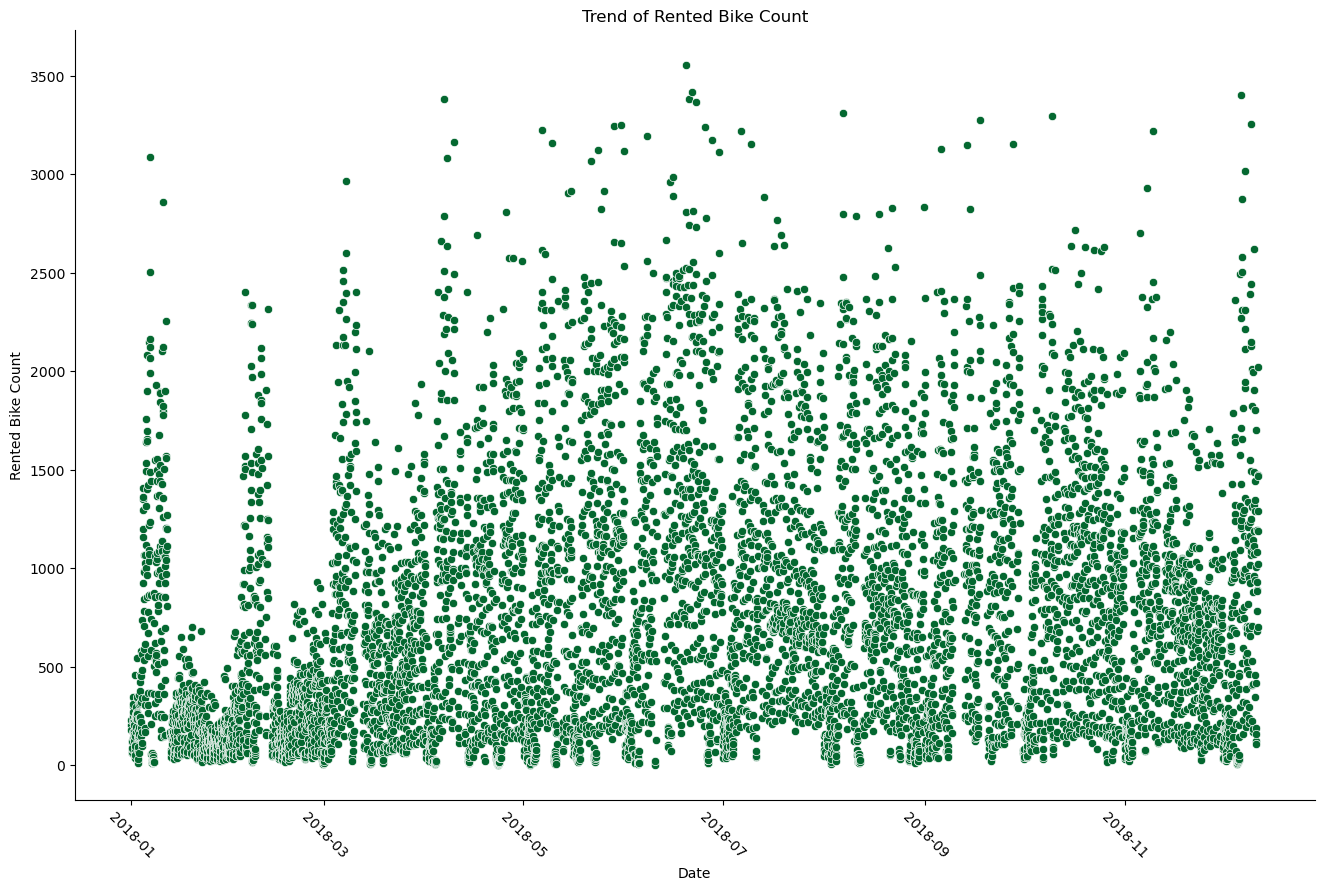

In [11]:
plt.figure(figsize=(16, 10))

sns.scatterplot(x=d['Datetime'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            ci= None
            )

# Set title and labels
plt.title('Trend of Rented Bike Count')
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')

plt.xticks(rotation= -45)
# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


#### Histogram

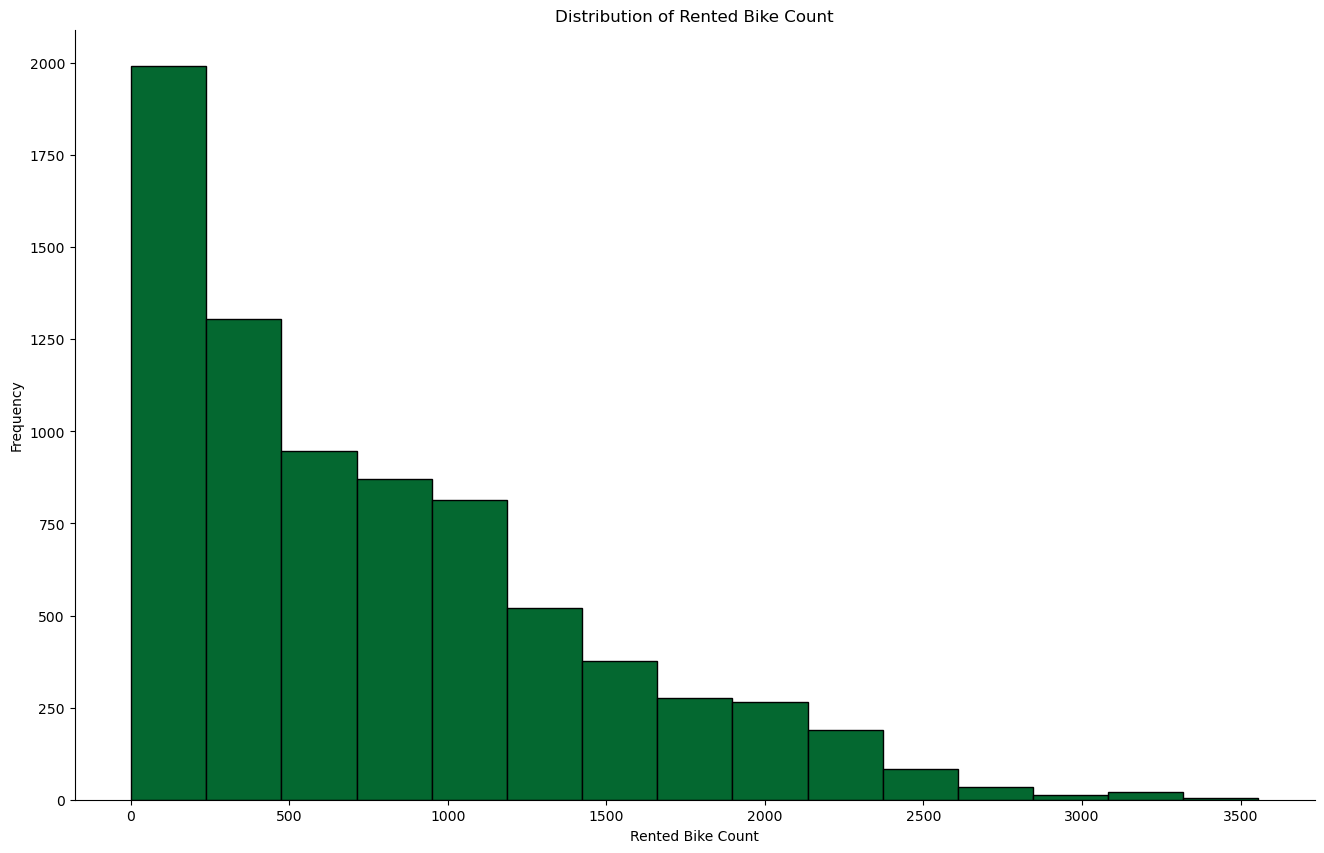

In [12]:
plt.figure(figsize=(16, 10))

plt.hist(d['Rented Bike Count'], bins=15, color='#046830', edgecolor='black')

# Set title and labels
plt.title('Distribution of Rented Bike Count')
plt.xlabel('Rented Bike Count')
plt.ylabel('Frequency')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show();


We can see from the histogram that for most of the days, the bike demand has been less than 1000 bikes per day.
Also we have some days that the demand was higher than usual around 3000.

#### Hourly Trend

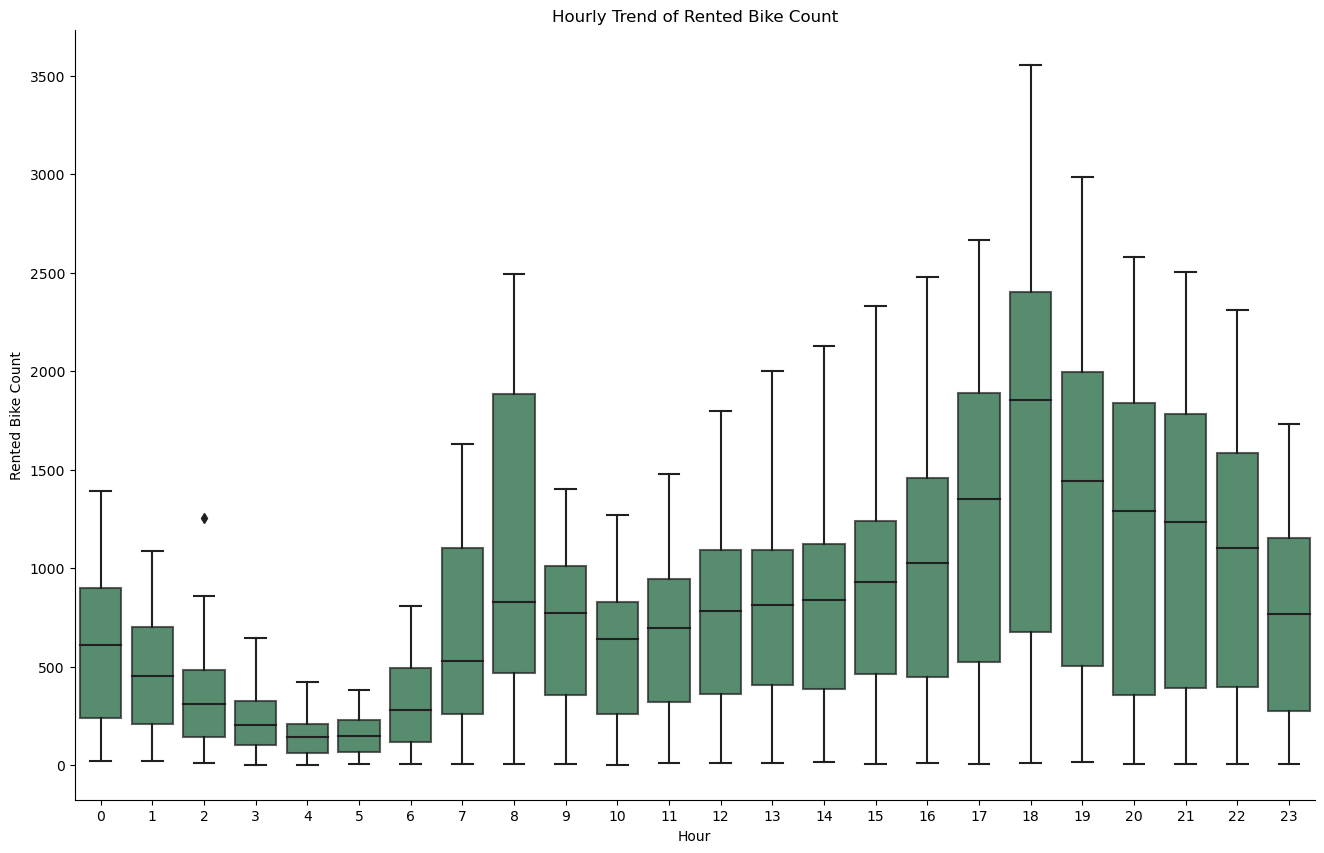

In [13]:
plt.figure(figsize=(16, 10))

sns.boxplot(x=d['Hour'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            boxprops=dict(alpha=.7))

# Set title and labels
plt.title('Hourly Trend of Rented Bike Count')
plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

We can see that the hourly demand for the bikes has two peaks. The first one is in the morning when people go to work and the second one is around the hour 19 at night when people come back from work.

#### Seasonal Trend

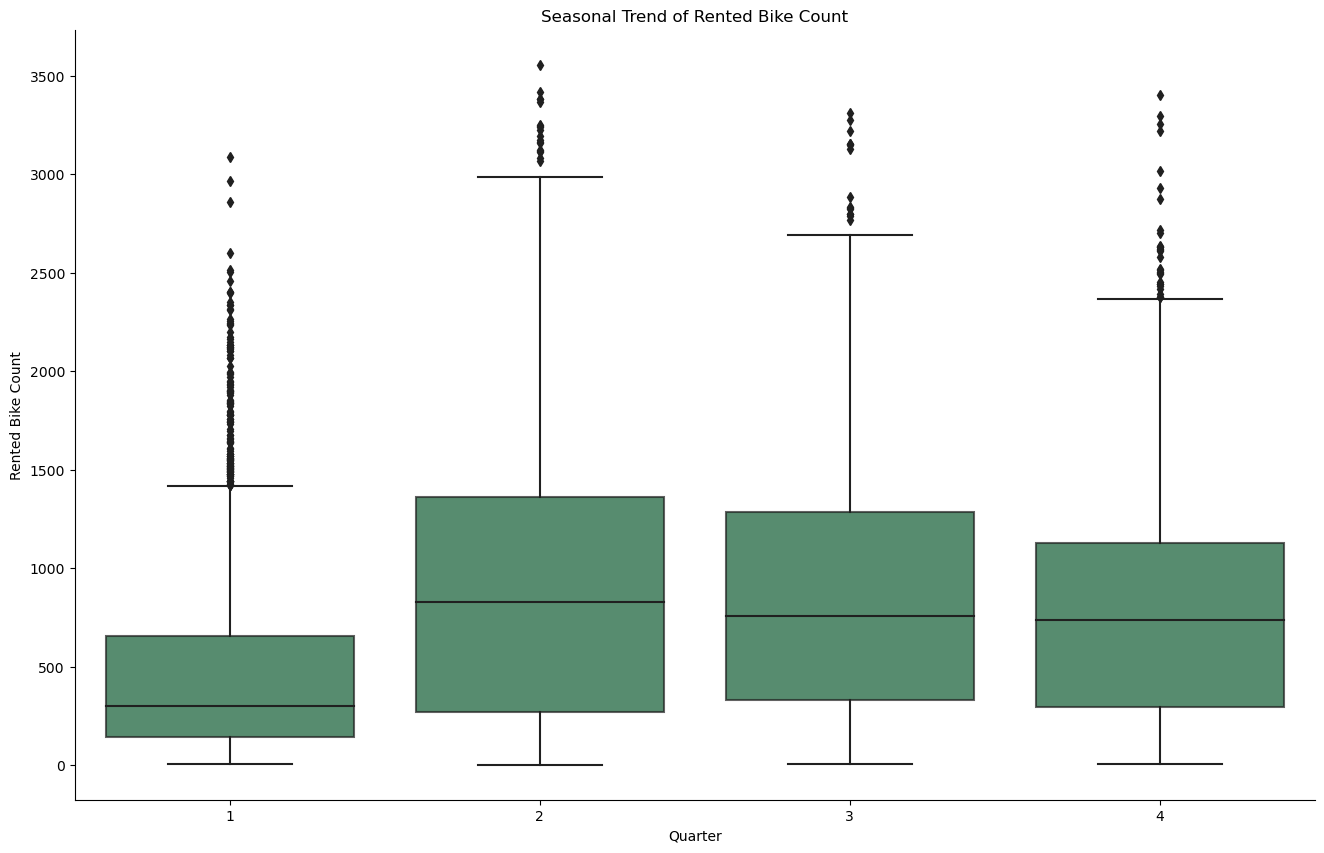

In [14]:
plt.figure(figsize=(16, 10))

d['Quarter']= d['Date'].dt.quarter

sns.boxplot(x=d['Quarter'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            boxprops=dict(alpha=.7))

# Set title and labels
plt.title('Seasonal Trend of Rented Bike Count')
plt.xlabel('Quarter')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show();

We can see that bikes has higher demand in summer and fall. Surprisingly, the demand in the spring is the lowest althogh the weather situation in this season is suitable for biking.

#### Weekly Trend

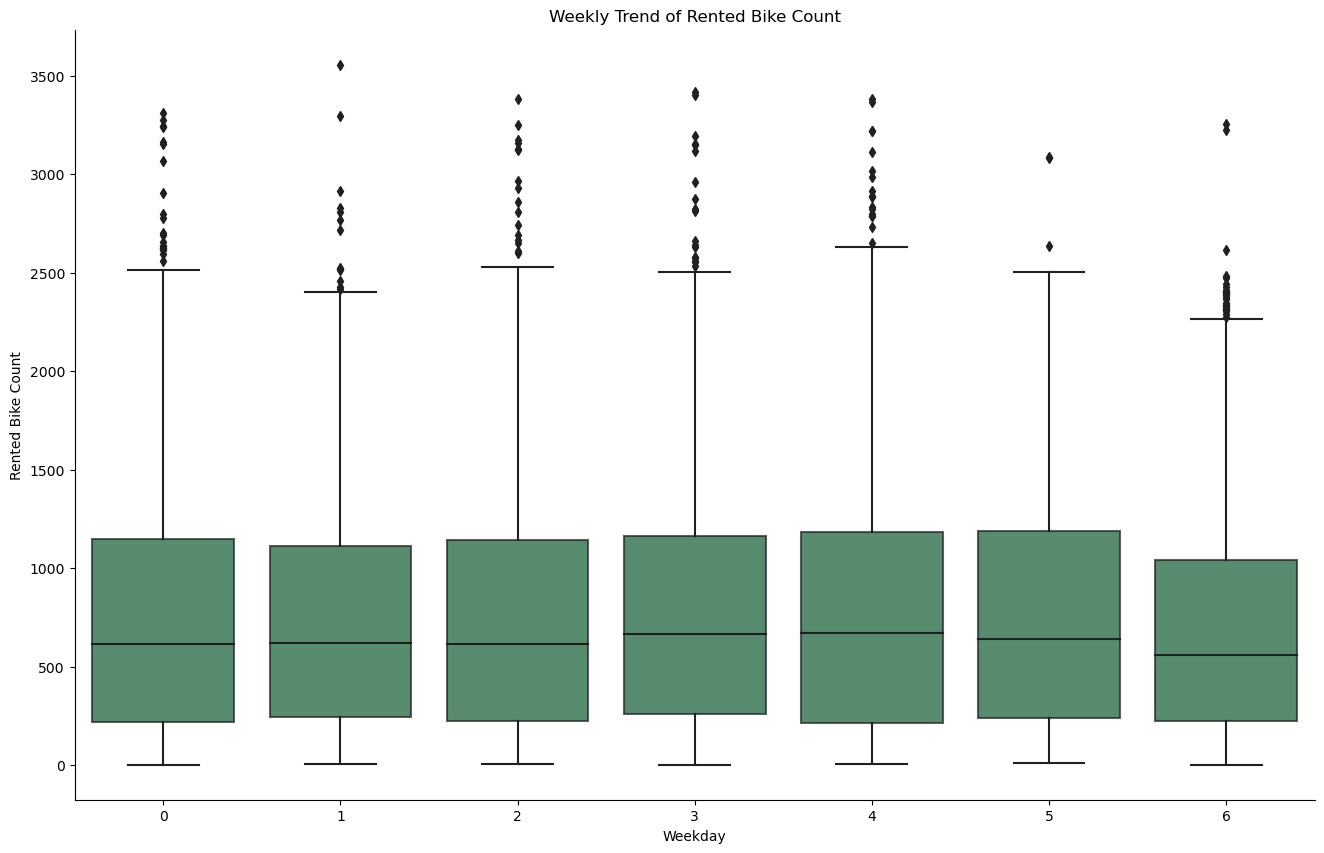

In [15]:
plt.figure(figsize=(16, 10))

d['Weekday']= d.Date.dt.weekday

sns.boxplot(x=d['Weekday'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            boxprops=dict(alpha=.7))

# Set title and labels
plt.title('Weekly Trend of Rented Bike Count')
plt.xlabel('Weekday')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


We can see that the boxplot can't show the difference between the days well. So we use the simple line chart for this part.

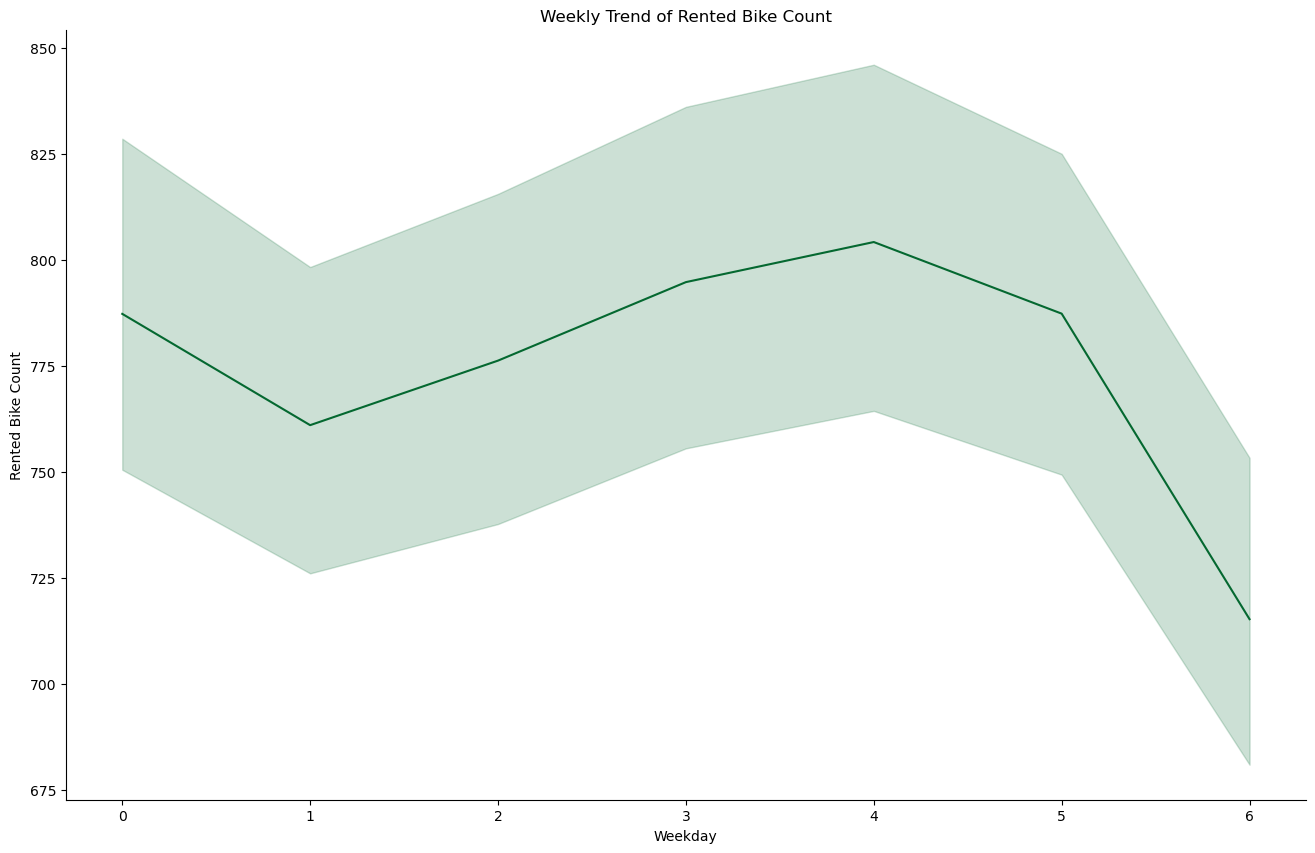

In [16]:
plt.figure(figsize=(16, 10))

sns.lineplot(x=d['Weekday'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            )

# Set title and labels
plt.title('Weekly Trend of Rented Bike Count')
plt.xlabel('Weekday')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


We can see from the line chart that the demand for working days is usually higher than weeekends. Interestingly, we can see that people do not prefer to bike in the first working days as they may be still tired after the weekends! So the ending working days have the highest demand.

### Part 2

#### Checking Normality

from the previous part, we can see that the demand doesn't have normal distribution. We use Anderson-Darling test to validate this observation.

In [17]:
rented_bike_count = d['Rented Bike Count']

# Perform Anderson-Darling test
result = anderson(rented_bike_count)

# Display the test results in a table
columns = ['Statistic', 'Critical Values', 'Significance Levels']
data = [result.statistic, result.critical_values, result.significance_level]
table_data = pd.DataFrame(data, index=columns, columns=['Value'])

# Print the table
print("Anderson-Darling Test Results for 'Rented Bike Count':")
print(table_data)

Anderson-Darling Test Results for 'Rented Bike Count':
                                                   Value
Statistic                                     214.736494
Critical Values      [0.576, 0.656, 0.787, 0.918, 1.091]
Significance Levels          [15.0, 10.0, 5.0, 2.5, 1.0]


The null hypothesis for the Anderson test is that the sample has normal distribution. Since this hypothesis is strongly rejected, we can validate our observation that the demand doesn't have normal distribution. So in the next part, we use Kruskal-Wallis test to check demand difference between holidays and working days.

#### Holiday Effect

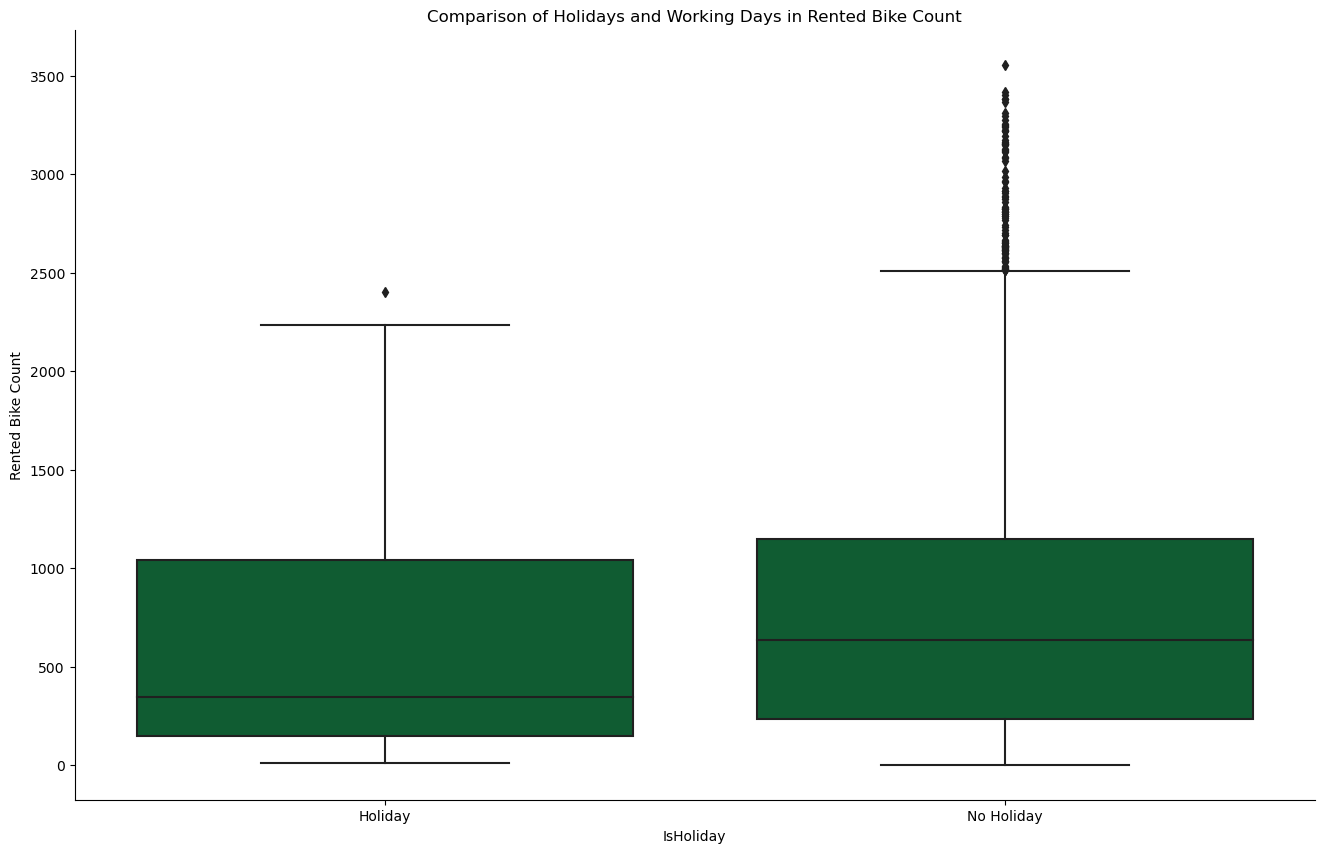

In [18]:
plt.figure(figsize=(16, 10))

sns.boxplot(x=d['Holiday'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            )

# Set title and labels
plt.title('Comparison of Holidays and Working Days in Rented Bike Count')
plt.xlabel('IsHoliday')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


From the plot we can see that the bike demand on working days is higher than holidays. We the similar results in the weekly trend in the previous part. As also mentioned there, this fact shows that people mostly use bikes to go or come back from work.

In [19]:
holiday_data = [d['Rented Bike Count'][d['Holiday'] == 'Holiday'], d['Rented Bike Count'][d['Holiday'] == 'No Holiday']]

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*holiday_data)

# Display the test results in a table
columns = ['Statistic', 'p-value']
data = [statistic, p_value]
table_data = pd.DataFrame(data, index=columns, columns=['Value'])

# Print the table
print("Kruskal-Wallis Test Results for Rented Bike Count and Holiday:")
print(table_data)


Kruskal-Wallis Test Results for Rented Bike Count and Holiday:
               Value
Statistic  20.858622
p-value     0.000005


This test is a non-parametric test and it's null hypothesis is that the medians of bike rental counts are equal across different holiday categories. We can see that the p-value is approximately zero, so we reject the null hypothesis and we can say that based on the test, the medians are not equal and there is a difference for the demand between holidays and working days.

### Part 3

#### Correlation Analysis

In [20]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7721 entries, 744 to 8759
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       7721 non-null   datetime64[ns]
 1   Rented Bike Count          7721 non-null   int64         
 2   Hour                       7721 non-null   int64         
 3   Temperature(°C)            7721 non-null   float64       
 4   Humidity(%)                7721 non-null   int64         
 5   Wind speed (m/s)           7721 non-null   float64       
 6   Visibility (10m)           7721 non-null   int64         
 7   Dew point temperature(°C)  7721 non-null   float64       
 8   Solar Radiation (MJ/m2)    7721 non-null   float64       
 9   Rainfall(mm)               7721 non-null   float64       
 10  Snowfall (cm)              7721 non-null   float64       
 11  Seasons                    7721 non-null   object        
 12  Holi

We first classify the features.

In [21]:
cols_numeric= d.select_dtypes([int, float]).columns.tolist()
print(d.select_dtypes([int, float]).columns)

Index(['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Quarter',
       'Weekday'],
      dtype='object')


We see some of these columns are not really numeric like hour, quarter, and weekday. We seperate them first.

In [22]:
cols_numeric_cat= ['Hour', 'Quarter', 'Weekday']
cols_numeric= list(set(cols_numeric)- set(cols_numeric_cat))

In [23]:
cols_cat= d.select_dtypes(['object']).columns.tolist()

# we also have quarter in the season column so we remove that
cols_cat= list(set(cols_cat)| set(cols_numeric_cat)- {'Quarter'})

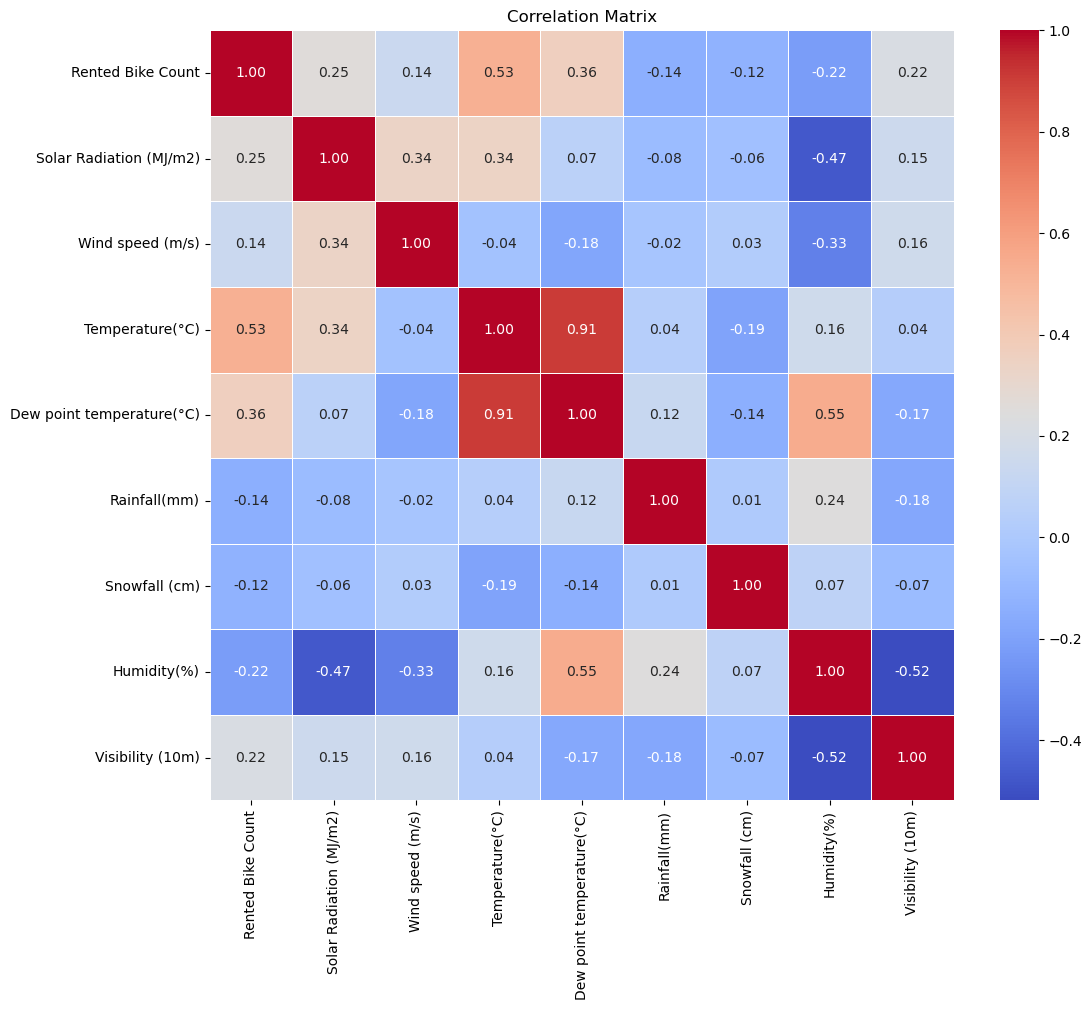

In [24]:
cols_numeric.remove('Rented Bike Count')
correlation_matrix = d[['Rented Bike Count']+ cols_numeric].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Set title
plt.title('Correlation Matrix')

# Show the plot
plt.show()


The above plot shows the correlation matrix of the numeric variables. The things is that to train the lasso model, we also need the non-numeric variables. So we first find these columns and then tranform them and then use them for training. 

We can see that the columns Temprature and Dew Temprature has a very high correlation:

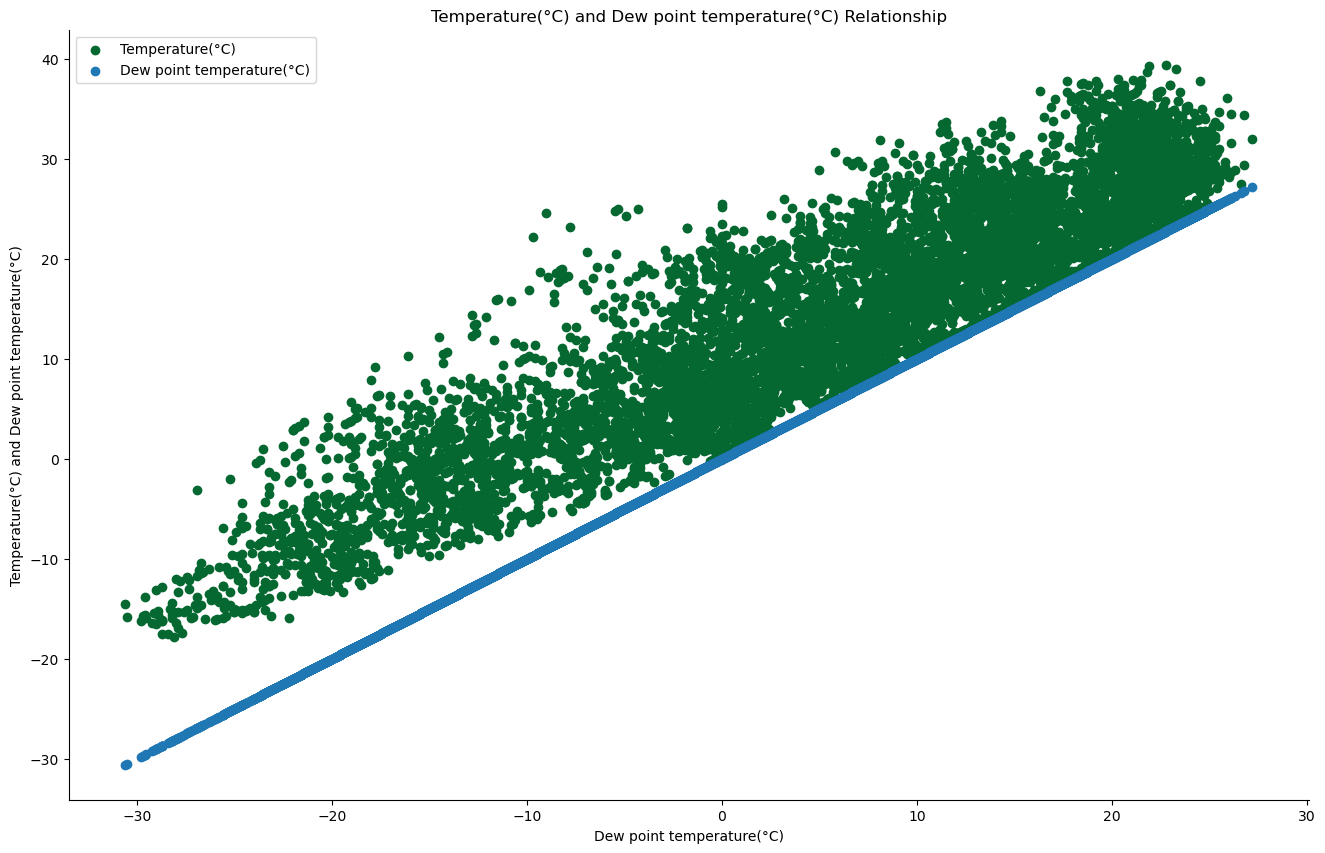

In [25]:
plt.figure(figsize=(16, 10))

plt.scatter(d['Dew point temperature(°C)'], 
            d['Temperature(°C)'], 
            label= 'Temperature(°C)',
            color= '#046830'
            )
plt.scatter(d['Dew point temperature(°C)'], d['Dew point temperature(°C)'], label= 'Dew point temperature(°C)')
plt.legend()

# Set title and labels
plt.title('Temperature(°C) and Dew point temperature(°C) Relationship')
plt.xlabel('Dew point temperature(°C)')
plt.ylabel('Temperature(°C) and Dew point temperature(°C)')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


Based on the geographical facts, Temprature is always higher than the Dew temprature. We can also see this fact in the chart above. To capture the information of both of these features, we remove the Dew temp. but we add the difference between these two as a new feature.

In [26]:
d['TempDiff']= d['Temperature(°C)']- d['Dew point temperature(°C)']
d= d.drop('Dew point temperature(°C)', axis= 1)
cols_numeric= cols_numeric+ ['TempDiff']
cols_numeric.remove('Dew point temperature(°C)')

Now we plot the correlation matrix again.

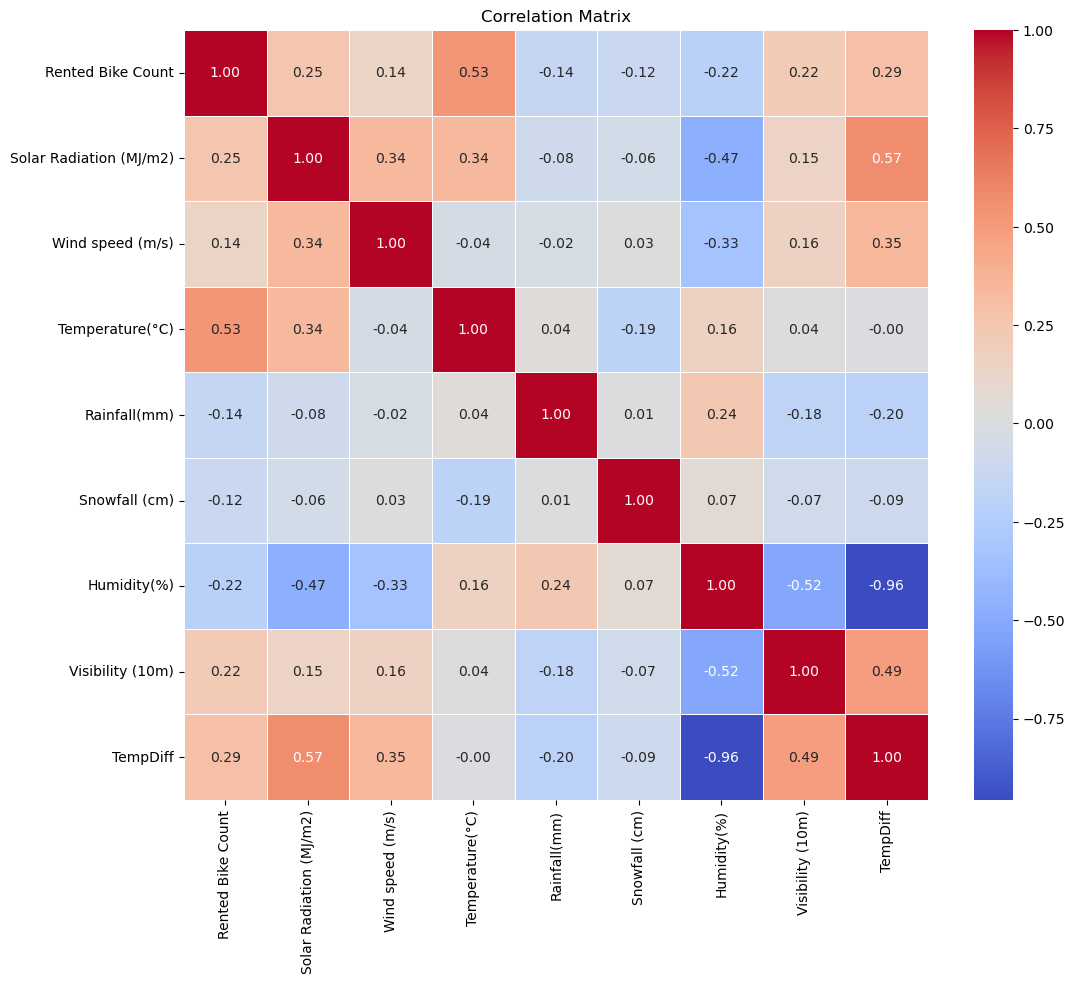

In [27]:
correlation_matrix = d[['Rented Bike Count']+ cols_numeric].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Set title
plt.title('Correlation Matrix')

# Show the plot
plt.show()


Now we see that Humidity% and the new feature we created have a high correlaion. This is because the closer the temp. and dew temp. the less the humidity%. After knowing this fact, we can easily remove the tempdiff feature too!

In [28]:
d= d.drop('TempDiff', axis= 1)
cols_numeric.remove('TempDiff')

We have the final list of categorical columns. So we use them all for the one-hot encoding. We then append the one-hot encoded data to the existing data. We then use this dataframe to train on the encoded and numeric columns.

#### Encoding

In [29]:
d_onehot= pd.get_dummies(d[cols_cat].astype(str), drop_first= True)
dt= pd.concat([d, d_onehot], axis= 1)
cols_train= list(set(cols_numeric+ d_onehot.columns.tolist()))

In [30]:
print('number of training columns', len(cols_train))

number of training columns 40


#### Lasso Regresion

Now that we have the list of the columns, we use the lasso regresion for feature selection. The point is that since Lasso has a term related to the number of the features in the model, some features would have 0 coef. in the Lasso so we can omit them from the model.

The thing is that first we have to tune the lasso parameter so the feature set would be optimal.

For creating this model and also the rest of the analysis, we create training, validation, and test data. We use validation data for the parameter tuning and the test data is only used in the final part for measuring metrics.

In [31]:
train_size= 0.7
valid_size= 0.15
test_size= 1- train_size- valid_size

In [32]:
index_train= d.head(int(train_size* len(d))).index
index_test= d.tail(int(test_size* len(d))).index
index_valid= d.drop(index_train.tolist()+ index_test.tolist()).index

print('Train Size:', len(index_train))
print('Valid Size:', len(index_valid))
print('Test Size:', len(index_test))


Train Size: 5404
Valid Size: 1159
Test Size: 1158


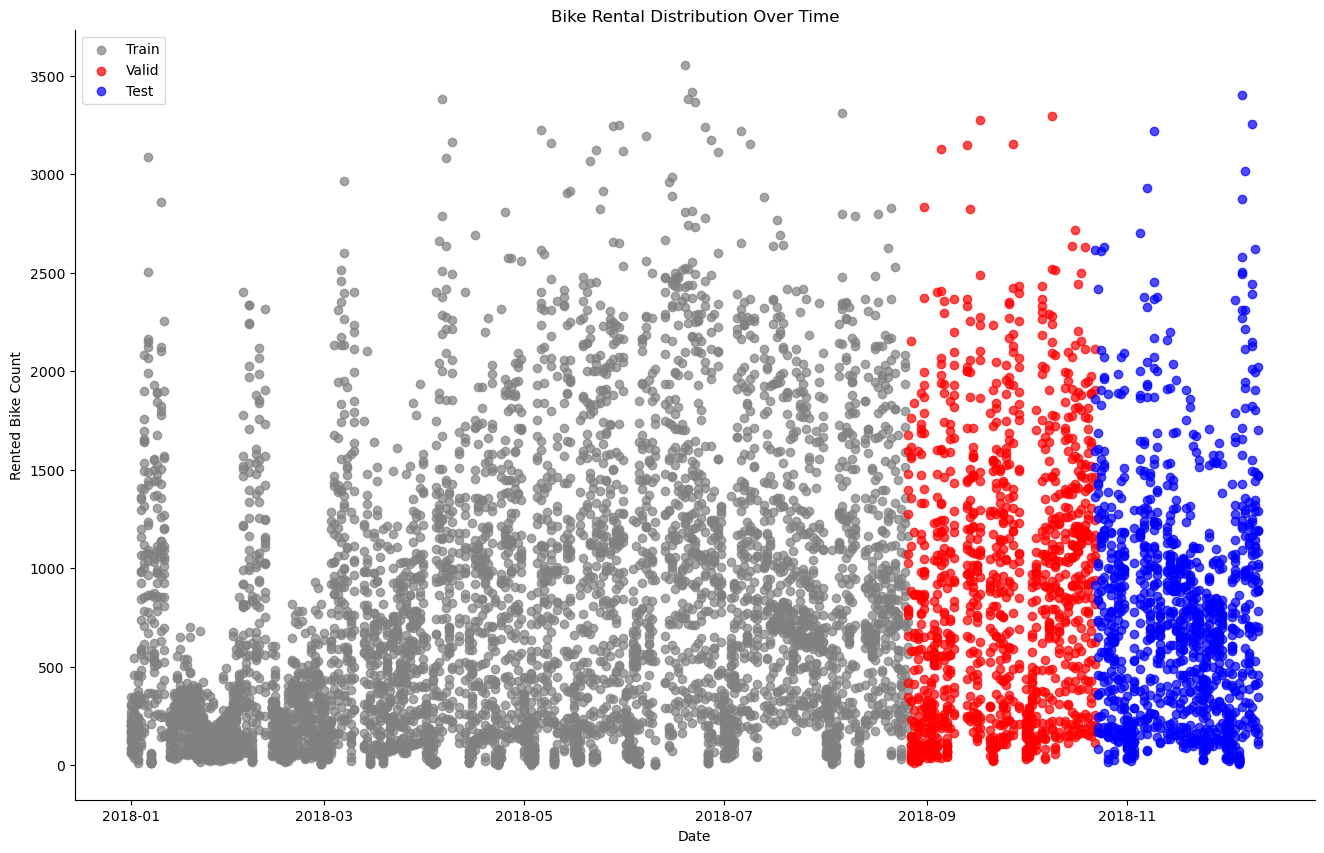

In [33]:
plt.figure(figsize=(16, 10))

# Scatter plots with minimal aesthetics
plt.scatter(d[d.index.isin(index_train)]['Date'], 
            d.iloc[d.index.isin(index_train)]['Rented Bike Count'], 
            label='Train', 
            color='gray', 
            marker='o', 
            alpha=0.7)

plt.scatter(d[d.index.isin(index_valid)]['Date'], 
            d[d.index.isin(index_valid)]['Rented Bike Count'], 
            label='Valid', 
            color='red', 
            marker='o', 
            alpha=0.7)
            
plt.scatter(d[d.index.isin(index_test)]['Date'], 
            d[d.index.isin(index_test)]['Rented Bike Count'], 
            label='Test', 
            color='blue', 
            marker='o', 
            alpha=0.7)

# Axes labels and title
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')
plt.title('Bike Rental Distribution Over Time')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()

# Remove grid
plt.grid(False)

# Show the plot
plt.show()

In the above chart we can see training, validation, and test data points. We now use the training and validation to find the best alpha for the lasso model.

In [34]:
def lassoCVcustom(
                d, 
                index_train, index_valid, alphas, 
                features, y, score_function):

    scores= []

    for i in range(len(alphas)):
        
        X_train= d[d.index.isin(index_train)][features]
        y_train= d[d.index.isin(index_train)][y]

        X_valid= d[d.index.isin(index_valid)][features]
        y_valid= d[d.index.isin(index_valid)][y]

        # we scale features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)

        model_lasso= Lasso(alpha= alphas[i])
        model_lasso.fit(X_train, y_train)

        y_pred_valid= model_lasso.predict(X_valid)

        score= score_function(y_valid, y_pred_valid)
        scores.append(score)


    results= pd.DataFrame()
    results['Alpha']= alphas
    results['Score']= scores

    return results

In [35]:
(d.index!= dt.index).sum()

0

In [36]:
y= 'Rented Bike Count'

alpha_lasso= lassoCVcustom(
    d= dt, 
    index_train= index_train, 
    index_valid= index_valid, 
    alphas= np.linspace(start= 0, stop= 50, num= 50), 
    features= cols_train, 
    y= y, 
    score_function= mean_squared_error)

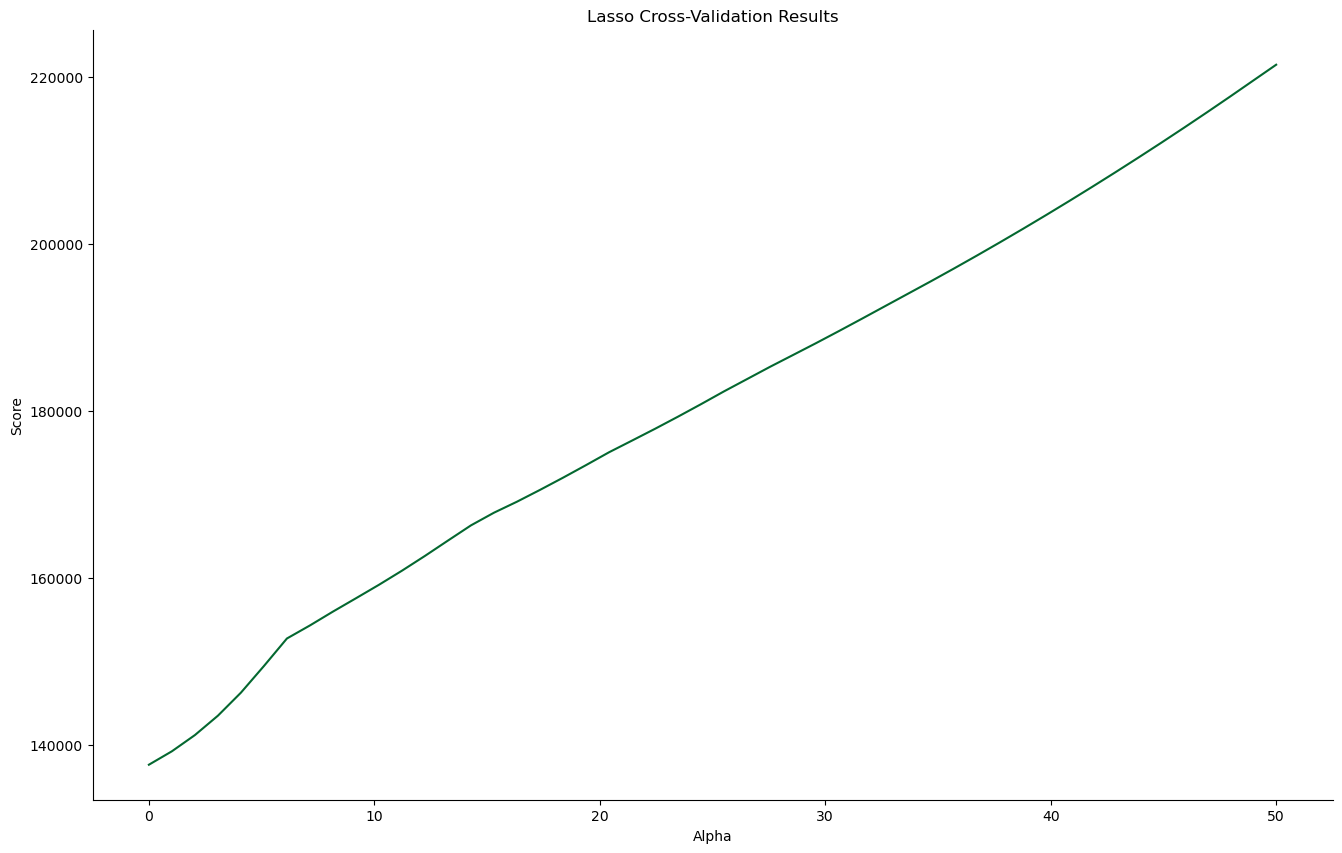

In [37]:
plt.figure(figsize=(16, 10))

sns.lineplot(alpha_lasso['Alpha'], 
            alpha_lasso['Score'],
            color= '#046830',
         )

# Axes labels and title
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Lasso Cross-Validation Results')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


We see that for alpha>0.5, MSE is increasing for alpha. So the best alpha is very small and in the first values.

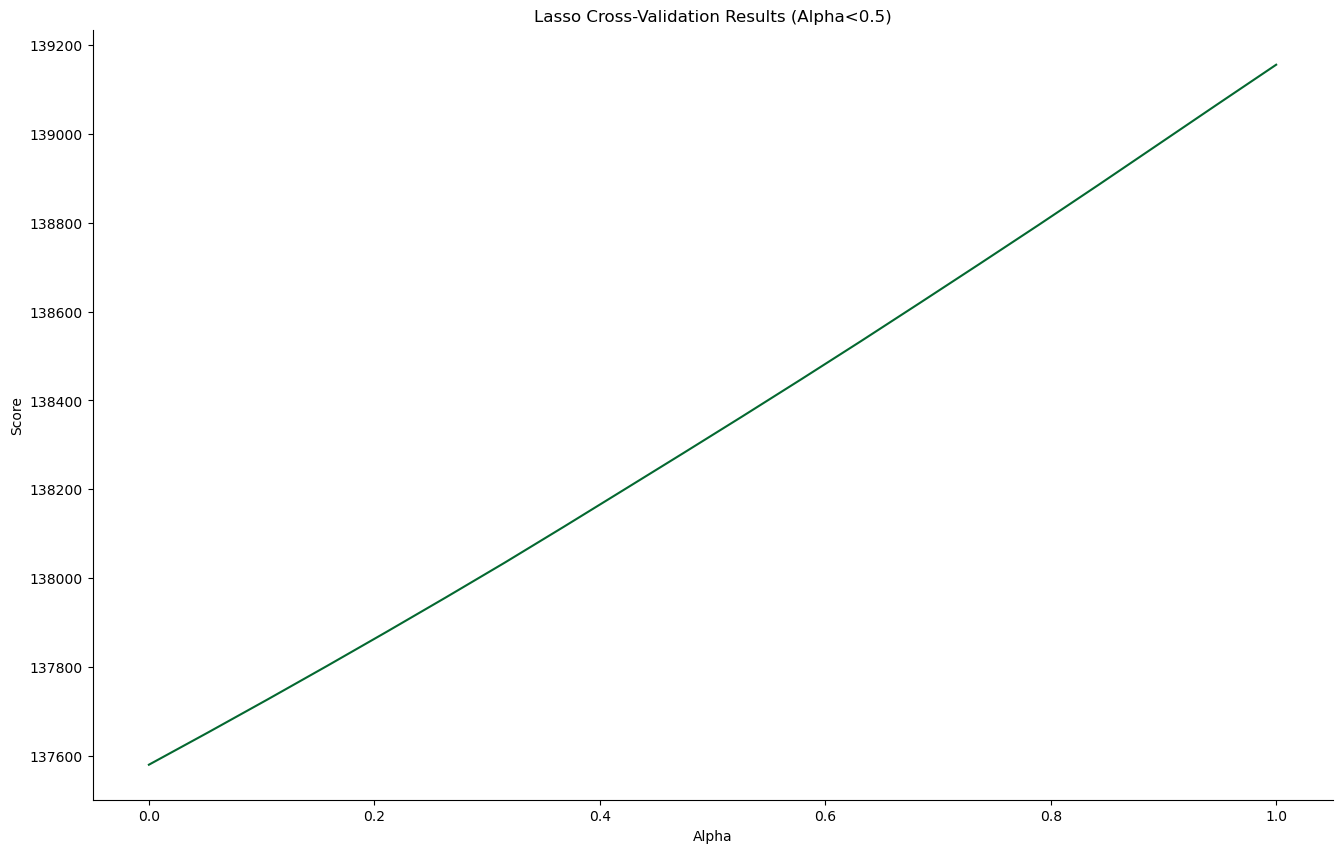

In [38]:
y= 'Rented Bike Count'

alpha_lasso= lassoCVcustom(
    d= dt, 
    index_train= index_train, 
    index_valid= index_valid, 
    alphas= np.linspace(start= 0, stop= 1, num= 20), 
    features= cols_train, 
    y= y, 
    score_function= mean_squared_error)

plt.figure(figsize=(16, 10))

sns.lineplot(alpha_lasso['Alpha'], 
            alpha_lasso['Score'],
            color= '#046830',
         )

# Axes labels and title
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Lasso Cross-Validation Results (Alpha<0.5)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


In [39]:
alpha_lasso[alpha_lasso['Score']== alpha_lasso['Score'].min()]

,Alpha,Score
0,0.0,137580.201566


We can see the alpha is zero! So we can say we can't remove any features based on the results of the lasso.

In [40]:
best_alpha_lasso = alpha_lasso[alpha_lasso['Score']== alpha_lasso['Score'].min()]\
                            ['Alpha'].values[0]

Now that we now the alpha, we train the lasso for both the train data and validation data to find features with zero coefficient.

In [41]:
X_train= dt[dt.index.isin(index_train.tolist()+ index_valid.tolist())][cols_train]
y_train= dt[dt.index.isin(index_train.tolist()+ index_valid.tolist())][y]

# we scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

model_lasso= Lasso(alpha= best_alpha_lasso)
model_lasso.fit(X_train, y_train)

Lasso(alpha=0.0)

In [42]:
lasso_coef= pd.DataFrame({'Feature': cols_train, 'Coefficient': model_lasso.coef_})\
    .sort_values('Coefficient')

lasso_coef

,Feature,Coefficient
1,Seasons_Winter,-193.831957
30,Humidity(%),-169.610656
36,Seasons_Spring,-88.360922
27,Hour_4,-79.210690
4,Hour_5,-77.132605
16,Rainfall(mm),-75.552124
33,Seasons_Summer,-72.152787
10,Hour_3,-66.375630
25,Hour_11,-48.647570
38,Hour_2,-48.343670


We see that the coefficient for two variables is so low that we can remove them from the model. We would further use this information for creating linear regresion.

### Part 4

For saving predictions to further compare them, we create a test dataframe.

In [43]:
d_test= d[d.index.isin(index_test)]
d_test.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Datetime,Quarter,Weekday
7578,2018-10-22,2613,18,17.3,43,0.9,783,0.08,0.0,0.0,Autumn,No Holiday,2018-10-22 18:00:00,4,0
7579,2018-10-22,1860,19,15.6,44,1.5,828,0.00,0.0,0.0,Autumn,No Holiday,2018-10-22 19:00:00,4,0
7580,2018-10-22,1593,20,14.5,51,1.4,751,0.00,0.0,0.0,Autumn,No Holiday,2018-10-22 20:00:00,4,0
7581,2018-10-22,1513,21,13.4,56,0.7,758,0.00,0.0,0.0,Autumn,No Holiday,2018-10-22 21:00:00,4,0
7582,2018-10-22,1360,22,12.7,60,0.0,680,0.00,0.0,0.0,Autumn,No Holiday,2018-10-22 22:00:00,4,0


#### Arima Model

since arima is a timeseries model, we only need the time related columns and rented numbers.

In [44]:
d_arima= dt[['Datetime', y]].sort_values('Datetime')
d_arima.set_index('Datetime', inplace=True)
d_arima.head()

,Rented Bike Count
Datetime,
2018-01-01 00:00:00,206
2018-01-01 01:00:00,230
2018-01-01 02:00:00,178
2018-01-01 03:00:00,119
2018-01-01 04:00:00,62


We use this data to get arima parameters

In [45]:
model_arima= pm.auto_arima(
    d_arima[y], 
    seasonal=False, 
    suppress_warnings=True,
    test= 'adf',
    max_p= 5, max_q= 5,
    start_p= 1, start_q= 1,
    m= 1,
    d= None,
    start_P= 0,
    D= 0,
    trace= True,
    error_action= 'ignore',
    stepwise= True
)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=109322.303, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=128787.228, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=109905.518, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=120602.864, Time=0.76 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=109318.389, Time=0.80 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=109424.969, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=109305.981, Time=1.40 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=109311.732, Time=0.33 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=109299.208, Time=2.46 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=109299.502, Time=0.33 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=6.84 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=108755.202, Time=6.41 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=109158.802, Time=2.36 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=108719.485, Time=6.63 sec
 ARIMA(5,0,3

In [46]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7721
Model:               SARIMAX(5, 0, 3)   Log Likelihood              -54335.773
Date:                Thu, 30 Nov 2023   AIC                         108689.545
Time:                        20:38:41   BIC                         108752.111
Sample:                             0   HQIC                        108710.999
                               - 7721                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1815      0.769      0.236      0.814      -1.326       1.689
ar.L2         -0.2332      0.553     -0.422      0.673      -1.316       0.850
ar.L3          0.7230      0.488      1.482      0.138      -0.233       1.679
ar.L4          0.3024      0.825      0.367      0.714      -1.314       1.919
ar.L5         -0.1650      0.215     -0.767      0.443      -0.587       0.257
ma.L1          1.0587      0.772      1.371      0.171      -0.455       2.573
ma.L2          1.2322      0.402      3.067      0.002       0.445       2.020
ma.L3          0.5132      0.737      0.697      0.486      -0.931       1.957
sigma2      7.747e+04    987.233     78.468      0.000    7.55e+04    7.94e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):              5545.62
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now we have the best order to use in the arima model, we train a model with that order.

In [47]:
best_arima_order= model_arima.order

In [48]:
model_arima_best= sm.tsa.ARIMA(d_arima, order= best_arima_order)
model_arima_best= model_arima_best.fit()

In [49]:
y_arima= model_arima_best.predict(
    start= len(d_arima),
    end= len(d_arima)+ len(index_test.tolist())- 1,
    typ= 'levels'
)
d_test['y_arima']= y_arima
y_arima.head()

7721    801.347228
7722    896.928016
7723    777.014424
7724    646.182455
7725    896.732748
Name: predicted_mean, dtype: float64

In [50]:
print('Test R2: ', r2_score(d_test[y], y_arima))

Test R2:  -0.01854547792129524


We see that arima is performing like the average and it's R2 is around 0 which is not good.

#### Linear Regresion

We use the simple linear regresion and train it on both the train and valid data using the selected features.

In [51]:
dt_LR= dt.copy()
selected_features= lasso_coef[lasso_coef['Coefficient']!= 0]['Feature'].tolist()
print(len(selected_features))

40


The thing is that linear regresion doesn't work well when the target value doesn't follow normal distribution. So we first transform the target so it would have normal distribution and then detransform it in the final prediction.

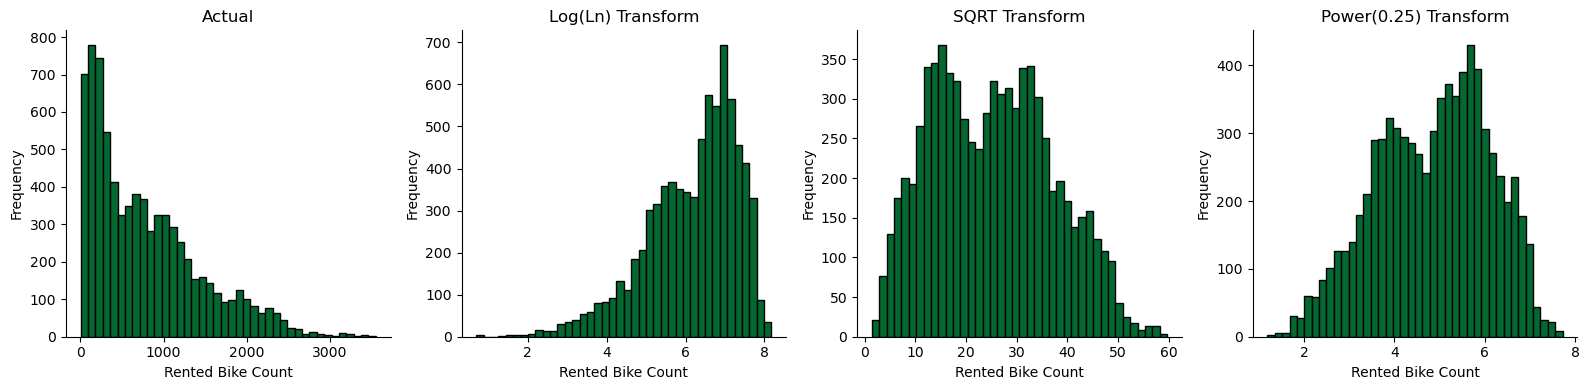

In [52]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Actual
axes[0].hist(dt_LR[y], bins=40, color='#046830', edgecolor='black')
axes[0].set_title('Actual')
axes[0].set_xlabel('Rented Bike Count')
axes[0].set_ylabel('Frequency')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Log Transform
axes[1].hist(np.log(dt_LR[y]), bins=40, color='#046830', edgecolor='black')
axes[1].set_title('Log(Ln) Transform')
axes[1].set_xlabel('Rented Bike Count')
axes[1].set_ylabel('Frequency')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Square Root Transform
axes[2].hist(np.sqrt(dt_LR[y]), bins=40, color='#046830', edgecolor='black')
axes[2].set_title('SQRT Transform')
axes[2].set_xlabel('Rented Bike Count')
axes[2].set_ylabel('Frequency')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# Power(0.25) Transform
axes[3].hist(np.power(dt_LR[y], 0.25), bins=40, color='#046830', edgecolor='black')
axes[3].set_title('Power(0.25) Transform')
axes[3].set_xlabel('Rented Bike Count')
axes[3].set_ylabel('Frequency')
axes[3].spines['top'].set_visible(False)
axes[3].spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [53]:
power= 0.25
X_train= dt_LR[dt_LR.index.isin(index_train.tolist()+ index_valid.tolist())][selected_features]
y_train= dt_LR[dt_LR.index.isin(index_train.tolist()+ index_valid.tolist())][y]

X_test= dt_LR[dt_LR.index.isin(index_test)][selected_features].sort_index()
y_test= dt_LR[dt_LR.index.isin(index_test)][y]

model_LR= LinearRegression()
model_LR.fit(X_train, y_train**power)

y_LR= model_LR.predict(X_test)**(1/ power)
y_LR_dt= model_LR.predict(X_train)**(1/ power)

d_test= d_test.sort_index()
d_test['y_LR']= y_LR
d_test['y_LR']= d_test['y_LR'].mask(d_test['y_LR']<0, 0).fillna(0)

print('Train R2: ', r2_score(y_train, y_LR_dt))
print('Test R2: ', r2_score(y_test, d_test['y_LR']))



Train R2:  0.6859872529396001
Test R2:  0.6350664457515074


The results are good and we can move on to next section. We would further analyze this results.

#### Random Forrest

For the random forrest, we add some new features since it can handle overfitting very well. The thing is that 

For the random forrest, we add some new features since it can handle overfitting very well. The thing is that we have a time series data and historical data can provide the model a good prediction power. So we use lags from the past days as a new feature.

In the last part, we should use the model to predict the demand for the next coming days. so lag features should come from days that are 3 or more days before.

Each row in data shows an hour. So we can use lags from 3*24 hours before or more.

In [54]:
dt_rf= dt.copy()

In [55]:
lags= [3* 24, 3* 25, 3* 26, 4* 24, 4* 25, 4* 26, 5* 24, 6* 24, 7* 24]
for lag in lags:
    dt_rf['lag_'+ str(lag)]= dt_rf.shift(lag)[y]

these lags would have some nan values:

In [56]:
cols_lag= [col for col in dt_rf.columns if 'lag' in col]
dt_rf[cols_lag].isna().sum()

lag_72      72
lag_75      75
lag_78      78
lag_96      96
lag_100    100
lag_104    104
lag_120    120
lag_144    144
lag_168    168
dtype: int64

Since the number of the nan values are not too much, we drop them.

In [57]:
dt_rf= dt_rf.dropna()

Since we dropped some data, the past train and valid index doesn't work anymore.

In [58]:
dt_rf_test= dt_rf[dt_rf.index.isin(index_test)]
dt_rf_train= dt_rf.drop(dt_rf_test.index)

In [59]:
dt_rf_train

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),...,Holiday_No Holiday,lag_72,lag_75,lag_78,lag_96,lag_100,lag_104,lag_120,lag_144,lag_168
912,2018-01-08,875,0,30.5,68,1.9,2000,0.00,0.0,0.0,...,1,782.0,983.0,1296.0,579.0,246.0,460.0,71.0,122.0,206.0
913,2018-01-08,724,1,29.9,70,1.0,2000,0.00,0.0,0.0,...,1,705.0,841.0,1066.0,453.0,212.0,423.0,147.0,149.0,230.0
914,2018-01-08,501,2,29.5,69,0.8,2000,0.00,0.0,0.0,...,1,534.0,588.0,984.0,322.0,190.0,317.0,180.0,103.0,178.0
915,2018-01-08,362,3,29.1,64,0.5,1997,0.00,0.0,0.0,...,1,343.0,782.0,983.0,221.0,190.0,231.0,92.0,81.0,119.0
916,2018-01-08,250,4,28.5,69,0.3,2000,0.00,0.0,0.0,...,1,187.0,705.0,841.0,147.0,579.0,246.0,28.0,37.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7573,2018-10-22,1064,13,19.4,35,1.2,678,1.73,0.0,0.0,...,1,1190.0,850.0,1188.0,1152.0,1165.0,185.0,1115.0,1108.0,1058.0
7574,2018-10-22,1122,14,20.6,30,2.2,839,1.69,0.0,0.0,...,1,1221.0,981.0,2113.0,1122.0,864.0,458.0,1083.0,1113.0,1121.0
7575,2018-10-22,1167,15,20.2,31,1.6,855,1.25,0.0,0.0,...,1,1390.0,1161.0,1191.0,1203.0,917.0,1191.0,1175.0,1203.0,1183.0
7576,2018-10-22,1464,16,19.7,34,1.6,688,0.88,0.0,0.0,...,1,1527.0,1190.0,850.0,1473.0,1132.0,2154.0,1409.0,1407.0,1413.0


In [60]:
train_size_rf= 0.85

dt_rf_train_index= dt_rf_train.head(int(train_size_rf* len(dt_rf_train))).index
dt_rf_valid_index= dt_rf_train.drop(dt_rf_train_index).index

print('train size', len(dt_rf_train_index))
print('test size', len(dt_rf_valid_index))


train size 5435
test size 960


Now we can use this dataframe for finding hyperparameters of the random forrest.

In [65]:
def find_best_params(data, index_train, index_valid, features, y, param_grid, model):


    # Initialize Random Forest Regressor
    grid_search = GridSearchCV(model, 
                           param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv= [[index_train, index_valid]],
                           verbose= 3,
                           n_jobs= -1,
                           )

    
    # Fit the model on the training data
    grid_search.fit(data[features],
                    data[y])

    # Get the best parameters
    best_params = grid_search.best_params_
    
    print(f"Best Parameters: {best_params}")
    
    return best_params


we choose n_estimators to be 200 as a normal number. We hypertune with this and then increae the number of trees.
It is obvious that increasing the number of trees would reduce the overfitting and both the test and train error and the only matter for increasing the number of trees is time.
 


In [75]:
model = RandomForestRegressor()

param_grid = {
    'n_estimators': [500],
    'max_depth': [None, 3, 5, 8],
    'min_samples_split': [1, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

In [64]:
dt_rf_train

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),...,Holiday_No Holiday,lag_72,lag_75,lag_78,lag_96,lag_100,lag_104,lag_120,lag_144,lag_168
912,2018-01-08,875,0,30.5,68,1.9,2000,0.00,0.0,0.0,...,1,782.0,983.0,1296.0,579.0,246.0,460.0,71.0,122.0,206.0
913,2018-01-08,724,1,29.9,70,1.0,2000,0.00,0.0,0.0,...,1,705.0,841.0,1066.0,453.0,212.0,423.0,147.0,149.0,230.0
914,2018-01-08,501,2,29.5,69,0.8,2000,0.00,0.0,0.0,...,1,534.0,588.0,984.0,322.0,190.0,317.0,180.0,103.0,178.0
915,2018-01-08,362,3,29.1,64,0.5,1997,0.00,0.0,0.0,...,1,343.0,782.0,983.0,221.0,190.0,231.0,92.0,81.0,119.0
916,2018-01-08,250,4,28.5,69,0.3,2000,0.00,0.0,0.0,...,1,187.0,705.0,841.0,147.0,579.0,246.0,28.0,37.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7573,2018-10-22,1064,13,19.4,35,1.2,678,1.73,0.0,0.0,...,1,1190.0,850.0,1188.0,1152.0,1165.0,185.0,1115.0,1108.0,1058.0
7574,2018-10-22,1122,14,20.6,30,2.2,839,1.69,0.0,0.0,...,1,1221.0,981.0,2113.0,1122.0,864.0,458.0,1083.0,1113.0,1121.0
7575,2018-10-22,1167,15,20.2,31,1.6,855,1.25,0.0,0.0,...,1,1390.0,1161.0,1191.0,1203.0,917.0,1191.0,1175.0,1203.0,1183.0
7576,2018-10-22,1464,16,19.7,34,1.6,688,0.88,0.0,0.0,...,1,1527.0,1190.0,850.0,1473.0,1132.0,2154.0,1409.0,1407.0,1413.0


In [76]:
rf_params= find_best_params(data= dt_rf_train, 
                            index_train= dt_rf_train_index.tolist(),
                            index_valid= dt_rf_valid_index.tolist(), 
                            features= cols_train+ cols_lag, 
                            y= y, 
                            param_grid= param_grid, 
                            model= model
                            )

Fitting 1 folds for each of 36 candidates, totalling 36 fits
